## Data

In [1]:
import pandas as pd

blueprinty = pd.read_csv('blueprinty.csv')
blueprinty.head()

,patents,region,age,iscustomer
0,0,Midwest,32.5,0
1,3,Southwest,37.5,0
2,4,Northwest,27.0,1
3,3,Northeast,24.5,0
4,3,Southwest,37.0,0


iscustomer
0    3.473013
1    4.133056
Name: patents, dtype: float64

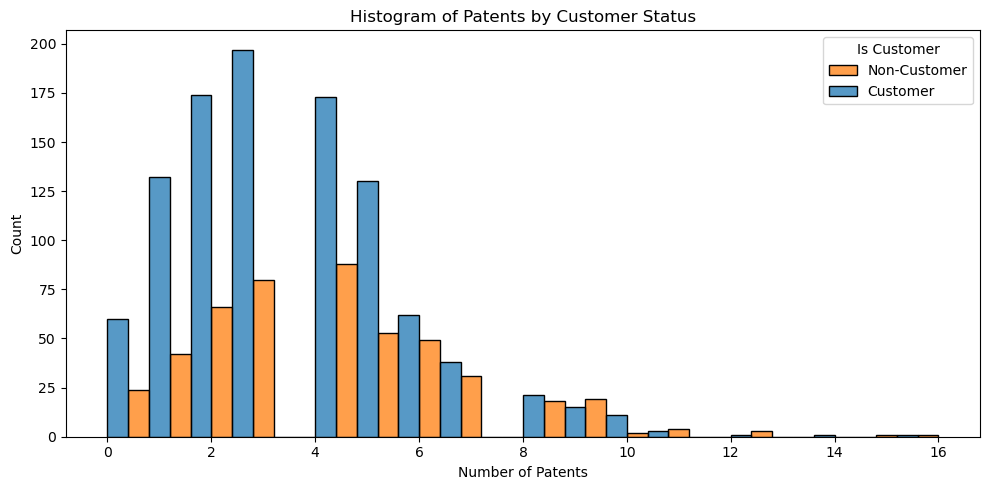

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute mean number of patents by customer status
mean_patents = blueprinty.groupby("iscustomer")["patents"].mean()

# Plot histogram of number of patents by customer status
plt.figure(figsize=(10, 5))
sns.histplot(data=blueprinty, x="patents", hue="iscustomer", multiple="dodge", bins=20)
plt.title("Histogram of Patents by Customer Status")
plt.xlabel("Number of Patents")
plt.ylabel("Count")
plt.legend(title="Is Customer", labels=["Non-Customer", "Customer"])
plt.tight_layout()

mean_patents


iscustomer,0,1
region,,
Midwest,83.5,16.5
Northeast,45.4,54.6
Northwest,84.5,15.5
South,81.7,18.3
Southwest,82.5,17.5


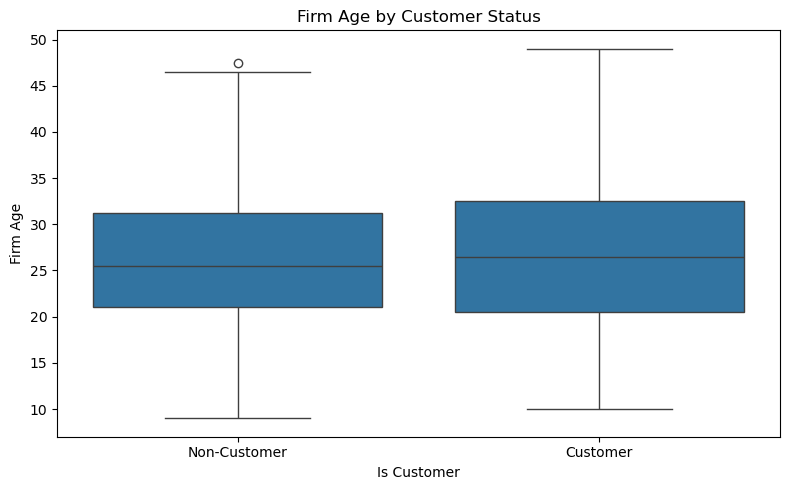

In [3]:
# Boxplot for firm age by customer status
plt.figure(figsize=(8, 5))
sns.boxplot(x="iscustomer", y="age", data=blueprinty)
plt.title("Firm Age by Customer Status")
plt.xlabel("Is Customer")
plt.ylabel("Firm Age")
plt.xticks([0, 1], ["Non-Customer", "Customer"])
plt.tight_layout()

# Crosstab for region by customer status
region_customer_crosstab = pd.crosstab(blueprinty["region"], blueprinty["iscustomer"], normalize='index') * 100
region_customer_crosstab.round(1)


## Estimation of Simple Poisson Model

In [4]:
import numpy as np
from scipy.special import gammaln

def poisson_loglikelihood(lmbda, Y):
    """
    Computes the negative log-likelihood of a Poisson model with scalar lambda.
    This is suitable for optimization routines like scipy.optimize.minimize.
    
    Parameters:
        lmbda : float
            The Poisson rate parameter (λ), must be > 0.
        Y : array-like
            Observed count data (e.g., number of patents).

    Returns:
        float : negative log-likelihood
    """
    if lmbda <= 0:
        return np.inf  # avoid invalid log(λ) or exp(−λ)
    
    Y = np.asarray(Y)
    log_lik = np.sum(Y * np.log(lmbda) - lmbda - gammaln(Y + 1))
    return log_lik  


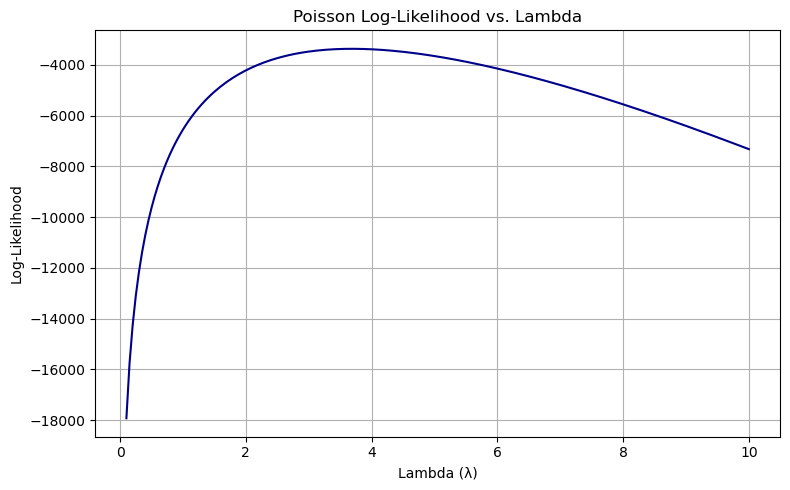

In [5]:
import matplotlib.pyplot as plt

Y = blueprinty["patents"].values

lambda_vals = np.linspace(0.1, 10, 200)
loglik_vals = [poisson_loglikelihood(lmb, Y) for lmb in lambda_vals]

plt.figure(figsize=(8, 5))
plt.plot(lambda_vals, loglik_vals, color='darkblue')
plt.title("Poisson Log-Likelihood vs. Lambda")
plt.xlabel("Lambda (λ)")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
from scipy.optimize import minimize

# Define the negative log-likelihood for use with optimizer
def neg_poisson_loglikelihood(lmbda, Y):
    if lmbda <= 0:
        return np.inf
    return -poisson_loglikelihood(lmbda, Y)

# Use the same Y from earlier
Y = blueprinty["patents"].values

# Use scipy to minimize the negative log-likelihood
result = minimize(fun=neg_poisson_loglikelihood, x0=[1.0], args=(Y,), bounds=[(1e-6, None)])
lambda_mle = result.x[0]
lambda_mle

3.6846667021660804

## Estimation of Poisson Regression Model

In [16]:
import numpy as np
from scipy.special import gammaln

# Define Poisson log-likelihood function (negative, stabilized)
def poisson_regression_loglik(beta, Y, X):
    eta = X @ beta
    eta = np.clip(eta, -20, 20)        # Prevent overflow in exp()
    lam = np.exp(eta)
    log_lik = np.sum(Y * eta - lam - gammaln(Y + 1))
    return -log_lik                   # Return negative for minimizer


In [17]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.special import gammaln
import patsy

# Create design matrix with intercept, age, age², region dummies, and customer
y, X = patsy.dmatrices('patents ~ age + I(age**2) + C(region) + iscustomer', data=blueprinty, return_type='dataframe')
Y = y.values.flatten()  # Convert y to 1D

# Initial guess for beta
beta0 = np.zeros(X.shape[1])

# Optimize the likelihood
result = minimize(poisson_regression_loglik, beta0, args=(Y, X), method='BFGS')

# Extract MLE estimates and standard errors
beta_hat = result.x
hessian_inv = result.hess_inv
standard_errors = np.sqrt(np.diag(hessian_inv))

# Present results in table
results_df = pd.DataFrame({
    "Coefficient": beta_hat,
    "Std. Error": standard_errors
}, index=X.columns)

print(results_df.round(4))


                        Coefficient  Std. Error
Intercept                   -0.5100      0.1931
C(region)[T.Northeast]       0.0292      0.0468
C(region)[T.Northwest]      -0.0176      0.0572
C(region)[T.South]           0.0566      0.0562
C(region)[T.Southwest]       0.0506      0.0497
age                          0.1487      0.0145
I(age ** 2)                 -0.0030      0.0003
iscustomer                   0.2076      0.0329


In [13]:
import statsmodels.api as sm

# Fit Poisson GLM with log link
glm_model = sm.GLM(Y, X, family=sm.families.Poisson())
glm_results = glm_model.fit()

# Display summary table
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1492
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3258.1
Date:                Sun, 04 May 2025   Deviance:                       2143.3
Time:                        17:40:46   Pearson chi2:                 2.07e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1360
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

In [18]:
# Create two counterfactual design matrices:
# - X_0: assumes all firms are non-customers (iscustomer = 0)
# - X_1: assumes all firms are customers (iscustomer = 1)
X_0 = X.copy()
X_1 = X.copy()

X_0["iscustomer"] = 0
X_1["iscustomer"] = 1

# Predict expected number of patents under both scenarios
y_pred_0 = np.exp(X_0 @ beta_hat)
y_pred_1 = np.exp(X_1 @ beta_hat)

# Compute difference and average effect
diff = y_pred_1 - y_pred_0
average_effect = diff.mean()

print(f"Average treatment effect of Blueprinty's software: {average_effect:.4f} additional patents")


Average treatment effect of Blueprinty's software: 0.7928 additional patents


# AirBnB Case Study

In [14]:
import pandas as pd

airbnb = pd.read_csv('airbnb.csv')

In [8]:
# Step 1: Explore structure
print(airbnb.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40628 entries, 0 to 40627
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 40628 non-null  int64  
 1   id                         40628 non-null  int64  
 2   days                       40628 non-null  int64  
 3   last_scraped               40628 non-null  object 
 4   host_since                 40593 non-null  object 
 5   room_type                  40628 non-null  object 
 6   bathrooms                  40468 non-null  float64
 7   bedrooms                   40552 non-null  float64
 8   price                      40628 non-null  int64  
 9   number_of_reviews          40628 non-null  int64  
 10  review_scores_cleanliness  30433 non-null  float64
 11  review_scores_location     30374 non-null  float64
 12  review_scores_value        30372 non-null  float64
 13  instant_bookable           40628 non-null  obj

In [12]:
print("\nMissing values per column:\n")
print(airbnb.isnull().sum())


Missing values per column:

Unnamed: 0                       0
id                               0
days                             0
last_scraped                     0
host_since                      35
room_type                        0
bathrooms                      160
bedrooms                        76
price                            0
number_of_reviews                0
review_scores_cleanliness    10195
review_scores_location       10254
review_scores_value          10256
instant_bookable                 0
dtype: int64


In [13]:
print("\nFirst few rows:\n")
airbnb.head()


First few rows:



,Unnamed: 0,id,days,last_scraped,host_since,room_type,bathrooms,bedrooms,price,number_of_reviews,review_scores_cleanliness,review_scores_location,review_scores_value,instant_bookable
0,1,2515,3130,4/2/2017,9/6/2008,Private room,1.0,1.0,59,150,9.0,9.0,9.0,f
1,2,2595,3127,4/2/2017,9/9/2008,Entire home/apt,1.0,0.0,230,20,9.0,10.0,9.0,f
2,3,3647,3050,4/2/2017,11/25/2008,Private room,1.0,1.0,150,0,NaN,NaN,NaN,f
3,4,3831,3038,4/2/2017,12/7/2008,Entire home/apt,1.0,1.0,89,116,9.0,9.0,9.0,f
4,5,4611,3012,4/2/2017,1/2/2009,Private room,NaN,1.0,39,93,9.0,8.0,9.0,t


In [ ]:
# Drop rows with missing values in key predictors
airbnb_clean = airbnb.dropna(subset=[
    "bathrooms",
    "bedrooms",
    "review_scores_cleanliness",
    "review_scores_location",
    "review_scores_value"
])

# Convert categorical variables
airbnb_clean["instant_bookable"] = airbnb_clean["instant_bookable"].map({"t": 1, "f": 0})

# One-hot encode room_type, drop one category to avoid multicollinearity
room_dummies = pd.get_dummies(airbnb_clean["room_type"], prefix="room", drop_first=True)

# Construct design matrix
X = pd.concat([
    airbnb_clean[[
        "price",
        "bedrooms",
        "bathrooms",
        "review_scores_cleanliness",
        "review_scores_location",
        "review_scores_value",
        "instant_bookable"
    ]],
    room_dummies
], axis=1)

# Add intercept manually
X.insert(0, "intercept", 1)

# Define target variable
Y = airbnb_clean["number_of_reviews"].values

# Show dimensions for confirmation
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (30160, 10)
Y shape: (30160,)


/tmp/ipykernel_7096/1035868469.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb_clean["instant_bookable"] = airbnb_clean["instant_bookable"].map({"t": 1, "f": 0})


In [22]:
import statsmodels.api as sm

# Ensure all columns in X are numeric
X = X.astype(float)

# Fit the Poisson regression model
poisson_model = sm.GLM(Y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# View the results
print(poisson_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                30160
Model:                            GLM   Df Residuals:                    30150
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.2900e+05
Date:                Mon, 05 May 2025   Deviance:                   9.3653e+05
Time:                        11:28:24   Pearson chi2:                 1.41e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5649
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept             

# HW3 Python Code

In [17]:
import pandas as pd

df = pd.read_csv('conjoint_data.csv')
df.head()

,resp,task,choice,brand,ad,price
0,1,1,1,N,Yes,28
1,1,1,0,H,Yes,16
2,1,1,0,P,Yes,16
3,1,2,0,N,Yes,32
4,1,2,1,P,Yes,16


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   resp    3000 non-null   int64 
 1   task    3000 non-null   int64 
 2   choice  3000 non-null   int64 
 3   brand   3000 non-null   object
 4   ad      3000 non-null   object
 5   price   3000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 140.8+ KB


In [19]:
# One-hot encode brand and ad
df_encoded = pd.get_dummies(df, columns=['brand', 'ad'], drop_first=True)

# Sort and reset index
df_encoded = df_encoded.sort_values(by=['resp', 'task']).reset_index(drop=True)

# Verify that each task has 3 rows (alternatives)
task_counts = df_encoded.groupby(['resp', 'task']).size()
assert (task_counts == 3).all(), "Each task should have 3 alternatives"

df_encoded.head()

,resp,task,choice,price,brand_N,brand_P,ad_Yes
0,1,1,1,28,True,False,True
1,1,1,0,16,False,False,True
2,1,1,0,16,False,True,True
3,1,2,0,32,True,False,True
4,1,2,1,16,False,True,True


In [20]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Load and encode
df = pd.read_csv("conjoint_data.csv")
df_encoded = pd.get_dummies(df, columns=['brand', 'ad'], drop_first=True)
df_encoded = df_encoded.sort_values(by=['resp', 'task']).reset_index(drop=True)

# Convert booleans to floats (important!)
X = df_encoded[['brand_N', 'brand_P', 'ad_Yes', 'price']].astype(float).values
y = df_encoded['choice'].values

# Reshape to choice-task format
n_alternatives = 3
n_obs = len(y) // n_alternatives
X_grouped = X.reshape((n_obs, n_alternatives, -1))
y_grouped = y.reshape((n_obs, n_alternatives))

# Negative log-likelihood function
def neg_log_likelihood(beta):
    ll = 0
    for i in range(n_obs):
        utilities = X_grouped[i] @ beta
        probs = np.exp(utilities) / np.sum(np.exp(utilities))
        ll += np.log(probs[y_grouped[i] == 1][0])
    return -ll

# Initial guess and estimation
initial_beta = np.zeros(X.shape[1])
result = minimize(neg_log_likelihood, initial_beta, method='BFGS')

# Extract results
beta_hat = result.x
hessian_inv = result.hess_inv
standard_errors = np.sqrt(np.diag(hessian_inv))
ci_lower = beta_hat - 1.96 * standard_errors
ci_upper = beta_hat + 1.96 * standard_errors

# Summary
summary_df = pd.DataFrame({
    'Coefficient': beta_hat,
    'Std. Error': standard_errors,
    '95% CI Lower': ci_lower,
    '95% CI Upper': ci_upper
}, index=['brand_N', 'brand_P', 'ad_Yes', 'price'])

print(summary_df)


         Coefficient  Std. Error  95% CI Lower  95% CI Upper
brand_N     0.941195    0.018302      0.905323      0.977068
brand_P     0.501616    0.004777      0.492252      0.510979
ad_Yes     -0.731994    0.004563     -0.740938     -0.723051
price      -0.099480    0.005067     -0.109413     -0.089548


In [21]:
import pandas as pd
import numpy as np

# Log-prior: N(0, 0.05^2) for binary vars, N(0, 0.005^2) for price
def log_prior(beta):
    prior_sd = np.array([0.05, 0.05, 0.05, 0.005])
    return -0.5 * np.sum((beta / prior_sd)**2) - np.sum(np.log(prior_sd * np.sqrt(2 * np.pi)))

# Log-posterior
def log_posterior(beta):
    return -neg_log_likelihood(beta) + log_prior(beta)

# MCMC sampler
def metropolis_sampler(log_post, initial, n_samples=3000, proposal_sd=[0.05, 0.05, 0.05, 0.005]):
    samples = [initial]
    current_log_post = log_post(initial)
    np.random.seed(0)
    for _ in range(n_samples - 1):
        proposal = samples[-1] + np.random.normal(scale=proposal_sd)
        proposal_log_post = log_post(proposal)
        log_accept_ratio = proposal_log_post - current_log_post
        if np.log(np.random.rand()) < log_accept_ratio:
            samples.append(proposal)
            current_log_post = proposal_log_post
        else:
            samples.append(samples[-1])
    return np.array(samples)

# Run it
initial_beta = np.zeros(X.shape[1])
mcmc_samples = metropolis_sampler(log_posterior, initial_beta)

# Discard burn-in
mcmc_samples = mcmc_samples[1000:]

# Posterior summary
posterior_means = mcmc_samples.mean(axis=0)
posterior_sds = mcmc_samples.std(axis=0)
posterior_ci_lower = np.percentile(mcmc_samples, 2.5, axis=0)
posterior_ci_upper = np.percentile(mcmc_samples, 97.5, axis=0)

posterior_summary = pd.DataFrame({
    "Posterior Mean": posterior_means,
    "Posterior SD": posterior_sds,
    "95% CI Lower": posterior_ci_lower,
    "95% CI Upper": posterior_ci_upper
}, index=['brand_N', 'brand_P', 'ad_Yes', 'price'])

print(posterior_summary)


         Posterior Mean  Posterior SD  95% CI Lower  95% CI Upper
brand_N        0.150717      0.047870      0.064154      0.248803
brand_P        0.024741      0.040724     -0.059125      0.104080
ad_Yes        -0.182542      0.043102     -0.265188     -0.092351
price         -0.041593      0.003704     -0.049004     -0.034733


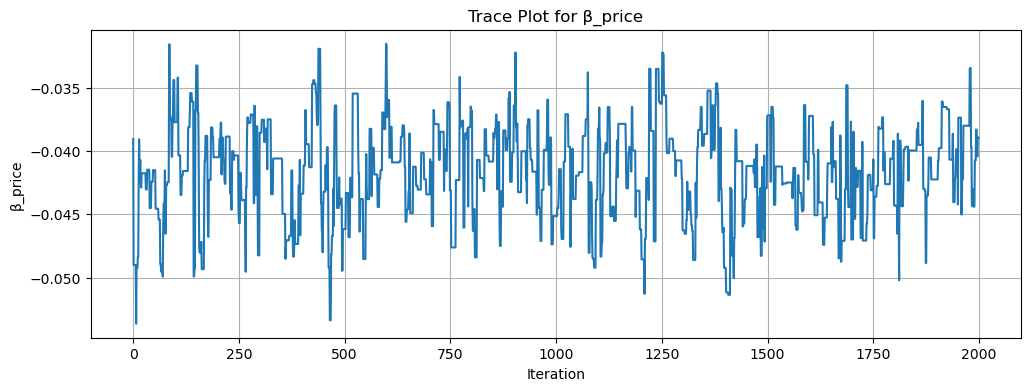

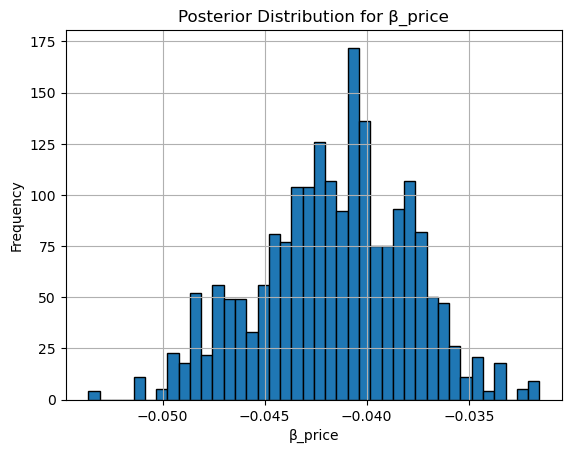

In [22]:
import matplotlib.pyplot as plt

# Trace plot for price
plt.figure(figsize=(12, 4))
plt.plot(mcmc_samples[:, 3])
plt.title("Trace Plot for β_price")
plt.xlabel("Iteration")
plt.ylabel("β_price")
plt.grid(True)
plt.show()

# Histogram for price
plt.hist(mcmc_samples[:, 3], bins=40, edgecolor='black')
plt.title("Posterior Distribution for β_price")
plt.xlabel("β_price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
